In [1]:
"""
5 runs of 50 epochs, seed = 10, 20, 30, 40, 50; 
validation accuracies: 0.9492, 0.9457, 0.9463, 0.9439, 0.9455
"""
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

PyTorch Version: 1.13.0
Torchvision Version: 0.14.0
GPU is available? True


## Read Data

In [2]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert to tensor and scale to [0, 1]
ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)

In [3]:
N = len(mnist_trainset)
N_test = len(mnist_testset)

x_train = torch.stack([data[0] for data in mnist_trainset][:N]).reshape(len(mnist_trainset), -1)
y_train = torch.LongTensor([data[1] for data in mnist_trainset][:N])
x_test = torch.stack([data[0] for data in mnist_testset][:N_test]).reshape(len(mnist_testset), -1)
y_test = torch.LongTensor([data[1] for data in mnist_testset][:N_test])

print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)
print("x_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

x_train.shape: torch.Size([60000, 784])
y_train.shape: torch.Size([60000])
x_test.shape: torch.Size([10000, 784])
y_test.shape: torch.Size([10000])


In [4]:
def relu_prox(a, b, gamma, d, N, device='cpu'):
    val = torch.empty(d,N, device=device)
    x = (a+gamma*b)/(1+gamma)
    y = torch.min(b,torch.zeros(d,N, device=device))

    val = torch.where(a+gamma*b < 0, y, torch.zeros(d,N, device=device))
    val = torch.where(((a+gamma*b >= 0) & (b >=0)) | ((a*(gamma-np.sqrt(gamma*(gamma+1))) <= gamma*b) & (b < 0)), x, val)
    val = torch.where((-a <= gamma*b) & (gamma*b <= a*(gamma-np.sqrt(gamma*(gamma+1)))), b, val)
    return val

In [10]:
class ThreeSplitBCD:
    def __init__(self, data_train, data_test, K, batch_size=128, device='cpu', hidden_sizes=None, depth=3, seed=42):
        """
        To reproduce the results in the paper, set batch_size to # of training samples.

        Args:
            hidden_sizes: a list of hidden layer sizes
            depth: the number of hidden layers
            K: the number of classes
        """
        self.K = K
        self.batch_size = batch_size
        self.x_train, self.y_train = data_train
        self.x_test, self.y_test = data_test
        self.device = device
        self.activation = nn.ReLU()
        self.activation_prox = relu_prox

        num_features = self.x_train.shape[1]
        if hidden_sizes is None:
            self.layer_sizes = [1500] * depth
        else:
            self.depth = len(hidden_sizes)
            self.layer_sizes = hidden_sizes
        self.layer_sizes = [num_features] + self.layer_sizes + [K]

        # Initialize of parameters
        self.params = []
        for l in range(len(self.layer_sizes) - 1):
            d,d_next = self.layer_sizes[l], self.layer_sizes[l+1]
            W = 0.01*torch.randn(d_next, d, device=device)
            b = 0.1*torch.ones(d_next, 1, device=device)
            self.params.append((W,b))

        self.gammas = [1] * len(self.params)
        self.alphas = [5] * (2 * len(self.params))
        self.rhos = [1] * len(self.params)
    
    def train(self, niter=50):
        # Preprocess data
        # sample batch from training data
        idx_tr = np.random.choice(self.x_train.shape[0], self.batch_size, replace=False)
        x_train, y_train = self.x_train[idx_tr,:], self.y_train[idx_tr]
        x_test, y_test = self.x_test, self.y_test

        x_train, y_train, y_one_hot = self.preprocess_data(x_train, y_train)
        x_test, y_test, _ = self.preprocess_data(x_test, y_test)

        # Forward pass to initialize the neural network states: U,V
        self.forward_pass(x_train)

        # Training logs
        loss1 = np.empty(niter)
        loss2 = np.empty(niter)
        accuracy_train = np.empty(niter)
        accuracy_test = np.empty(niter)
        time1 = np.empty(niter)

        # Backward pass to update the parameters
        for k in range(niter):
            start = time.time()
            self.backward_pass(x_train, y_train, y_one_hot)
            end = time.time()
            time1[k] = end - start

            # Compute loss and accuracy
            l1,l2,acc_tr,acc_te = self.compute_metrcs(x_train, y_train, y_one_hot, x_test, y_test)
            loss1[k] = l1
            loss2[k] = l2
            accuracy_train[k] = acc_tr
            accuracy_test[k] = acc_te

            # print results
            print('Epoch', k + 1, '/', niter, '\n', 
                '-', 'time:', time1[k], '-', 'sq_loss:', loss1[k], '-', 'tot_loss:', loss2[k], 
                '-', 'acc:', accuracy_train[k], '-', 'val_acc:', accuracy_test[k])
            
        return {
            'loss1': loss1,
            'loss2': loss2,
            'acc_tr': accuracy_train,
            'acc_te': accuracy_test,
            'time': time1
        }


    def forward_pass(self, x_train):
        """
        Initialization of the neural network states (output of each layer), corresponding to U,V in the paper.
        Args:
            x_train: tensor of shape (# of features, # of samples)
        """
        self.nn_states = []
        _, N = x_train.shape
        V = x_train
        for W,b in self.params[:-1]:
            U = torch.addmm(b.repeat(1,N), W, V)
            V = self.activation(U)
            self.nn_states.append((U,V))
        W,b = self.params[-1]
        U = torch.addmm(b.repeat(1,N), W, V)
        self.nn_states.append((U, U))

    def backward_pass(self, x_train, y_train, y_one_hot):
        """ this method correspond to one iteration of the inner loop in the paper """
        N = x_train.shape[1]

        for l in range(len(self.params)-1, -1, -1):

            # Retrive values from cache
            d = self.layer_sizes[l+1] # layer_sizes takes into account the input layer
            gamma = self.gammas[l]
            alpha_u, alpha_w = self.alphas[2*l], self.alphas[2*l+1]
            rho = self.rhos[l]
            W,b = self.params[l]
            U,V = self.nn_states[l]
            V_prev = self.nn_states[l-1][1] if l != 0 else x_train

            # Update V, U
            if l != len(self.params)-1:
                rho_next = self.rhos[l+1]
                W_next,b_next = self.params[l+1]
                U_next = self.nn_states[l+1][0]
                V = self.updateV(U,U_next,W_next,b_next,rho_next,gamma)
                U = self.activation_prox(V,(rho*torch.addmm(b.repeat(1,N), W, V_prev) + alpha_u*U)/(rho + alpha_u),(rho + alpha_u)/gamma,d,N, 
                                         device=self.device)
            else: # for the last layer
                V = (y_one_hot + gamma * U + alpha_u * V) / (1 + gamma + alpha_u)
                U = (gamma * V + rho*(torch.mm(W,V_prev) + b.repeat(1,N))) / (gamma + rho)

            # Update W, b
            W,b = self.updateWb(U,V_prev,W,b,alpha_w,rho)

            # Update cache for next iteration
            self.params[l] = (W,b)
            self.nn_states[l] = (U,V)

    def predict(self, x):
        N = x.shape[1]
        for W,b in self.params[:-1]:
            x = self.activation(torch.addmm(b.repeat(1,N), W, x))
        W,b = self.params[-1]
        pred = torch.argmax(torch.addmm(b.repeat(1, N), W, x), dim=0)
        return pred
    
    def compute_metrcs(self, x, y, y_one_hot, x_test=None, y_test=None):
        # Compute loss
        gamma = self.gammas[-1]
        V = self.nn_states[-1][1]
        loss1 = gamma/2 * torch.pow(torch.dist(V,y_one_hot,2),2).cpu().numpy()
        loss2 = loss1.copy()
        for l in range(len(self.params)):
            N = x.shape[1]
            rho = self.rhos[l]
            W,b = self.params[l]
            U = self.nn_states[l][0]
            V_prev = self.nn_states[l-1][1] if l != 0 else x
            loss2 += rho/2 * torch.pow(torch.dist(torch.addmm(b.repeat(1,N), W, V_prev),U,2),2).cpu().numpy()
        # Copmute accuracy
        correct = self.predict(x) == y
        acc = np.mean(correct.cpu().numpy())

        # Compute test accuracy
        if x_test is not None and y_test is not None:
            correct_test = self.predict(x_test) == y_test
            acc_test = np.mean(correct_test.cpu().numpy())
        else:
            acc_test = None
        
        return loss1, loss2, acc, acc_test
    

    def updateV(self, U1,U2,W,b,rho,gamma): 
        _, d = W.size()
        I = torch.eye(d, device=self.device)
        U1 = nn.ReLU()(U1)
        _, col_U2 = U2.size()
        Vstar = torch.mm(torch.inverse(rho*(torch.mm(torch.t(W),W))+gamma*I), rho*torch.mm(torch.t(W),U2-b.repeat(1,col_U2))+gamma*U1)
        return Vstar

    def updateWb(self, U, V, W, b, alpha, rho): 
        d,N = V.size()
        I = torch.eye(d, device=self.device)
        _, col_U = U.size()
        Wstar = torch.mm(alpha*W+rho*torch.mm(U-b.repeat(1,col_U),torch.t(V)),torch.inverse(alpha*I+rho*(torch.mm(V,torch.t(V)))))
        bstar = (alpha*b+rho*torch.sum(U-torch.mm(W,V), dim=1).reshape(b.size()))/(rho*N+alpha)
        return Wstar, bstar
    
    def preprocess_data(self, x, y):
        """ Suppose data x of shape (N, D) and y of shape (N,). 
        """
        N = x.shape[0]
        x = x.to(device=self.device).T
        y_one_hot = torch.zeros(N, self.K).scatter_(1, torch.reshape(y, (N, 1)), 1)
        y_one_hot = torch.t(y_one_hot).to(device=self.device)
        y = y.to(device=self.device)
        return x, y, y_one_hot

In [11]:
bcd_runner = ThreeSplitBCD((x_train,y_train), (x_test,y_test), K=10, batch_size=N, device=device, seed=42)


In [12]:
results = bcd_runner.train(50)

Epoch 1 / 50 
 - time: 1.6324987411499023 - sq_loss: 20307.88671875 - tot_loss: 20336.466096129152 - acc: 0.2814 - val_acc: 0.2827
Epoch 2 / 50 
 - time: 1.2394990921020508 - sq_loss: 15337.4052734375 - tot_loss: 15348.288642632542 - acc: 0.7740833333333333 - val_acc: 0.778
Epoch 3 / 50 
 - time: 1.2314989566802979 - sq_loss: 11787.5810546875 - tot_loss: 11794.091006553266 - acc: 0.8846 - val_acc: 0.8849
Epoch 4 / 50 
 - time: 1.228499174118042 - sq_loss: 9117.603515625 - tot_loss: 9122.877709739842 - acc: 0.90725 - val_acc: 0.91
Epoch 5 / 50 
 - time: 1.22999906539917 - sq_loss: 7067.60107421875 - tot_loss: 7072.833630071022 - acc: 0.9160333333333334 - val_acc: 0.9178
Epoch 6 / 50 
 - time: 1.229499340057373 - sq_loss: 5482.0439453125 - tot_loss: 5487.143444372341 - acc: 0.9205166666666666 - val_acc: 0.9211
Epoch 7 / 50 
 - time: 1.2305951118469238 - sq_loss: 4252.68310546875 - tot_loss: 4257.44492200762 - acc: 0.92475 - val_acc: 0.9237
Epoch 8 / 50 
 - time: 1.2384989261627197 - sq_l

Text(0.5, 1.0, 'accuracy')

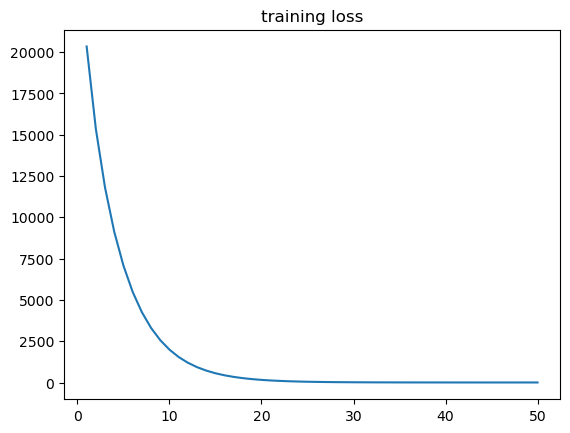

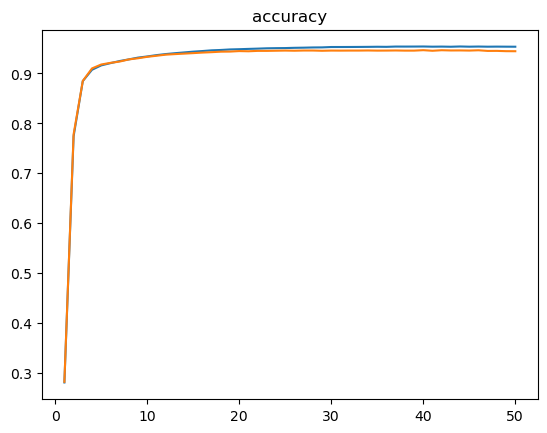

In [13]:
# retrieve results
loss1, loss2 = results['loss1'], results['loss2']
accuracy_train, accuracy_test = results['acc_tr'], results['acc_te']

niter=len(loss1)

plt.figure()
plt.plot(np.arange(1,niter+1), loss2)
plt.title('training loss')

plt.figure()
plt.plot(np.arange(1,niter+1), accuracy_train)
plt.plot(np.arange(1,niter+1), accuracy_test)
plt.title('accuracy')

In [16]:
b = 0.1*torch.ones(3,1)
b.repeat(1,5)

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000]])